Enabled memory growth for 1 GPU(s).
Unique sentiment labels before encoding: ['positive' 'negative' 'neutral']
Unique encoded sentiment labels: [0 1 2]


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing:   0%|          | 0/5842 [00:00<?, ?it/s]Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spac

Training samples: 4673
Testing samples: 1169


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

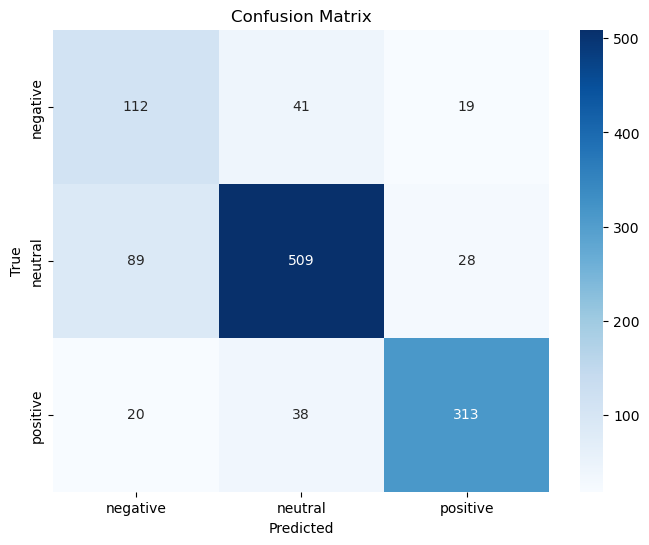

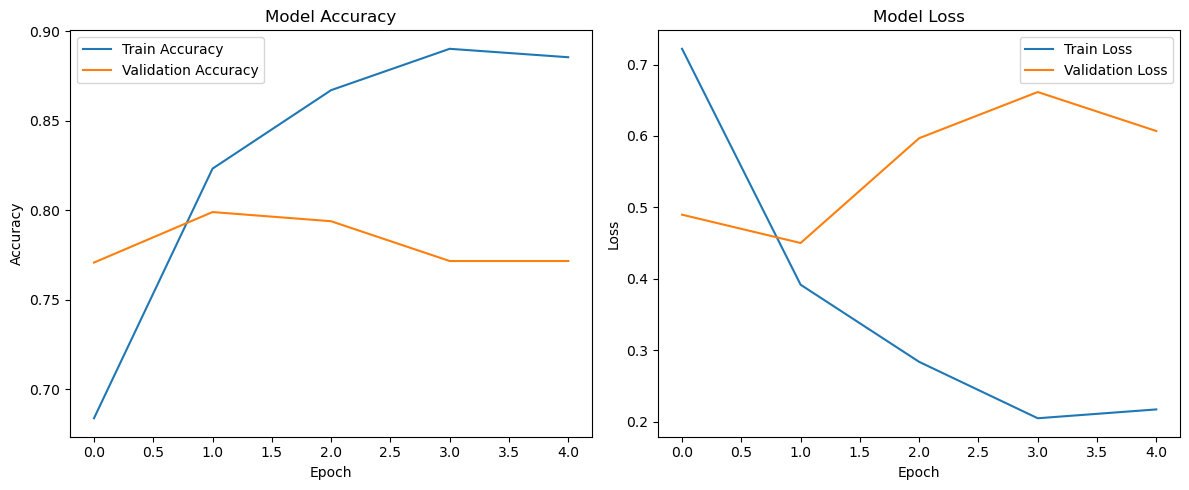

In [2]:
# sentiment_analysis_tensorflow.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import random
import os

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure 'data.csv' has at least two columns: 'Sentence' and 'Sentiment'
df = pd.read_csv("./data.csv")

# Check if necessary columns exist
if not {'Sentence', 'Sentiment'}.issubset(df.columns):
    raise ValueError("Dataset must contain 'Sentence' and 'Sentiment' columns.")

# Inspect unique sentiment labels before encoding
print("Unique sentiment labels before encoding:", df['Sentiment'].unique())

# Encode sentiment labels into integers
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# Verify encoded labels
print("Unique encoded sentiment labels:", np.unique(df['Sentiment']))

# Define maximum sequence length
MAX_LEN = 128

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the sentences
def tokenize_sentences(sentences, tokenizer, max_len):
    input_ids = []
    attention_masks = []
    
    for sent in tqdm(sentences, desc="Tokenizing"):
        encoded = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf',
            clean_up_tokenization_spaces=True  # Explicitly set to suppress warning
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return (
        tf.concat(input_ids, axis=0),
        tf.concat(attention_masks, axis=0)
    )

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df['Sentence'].values, tokenizer, MAX_LEN)

# Convert TensorFlow tensors to NumPy arrays
input_ids = input_ids.numpy()
attention_masks = attention_masks.numpy()

# Define labels
labels = df['Sentiment'].values

# Split the data into training and testing sets
X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {X_train_ids.shape[0]}")
print(f"Testing samples: {X_test_ids.shape[0]}")

# -------------------------------
# 3. Model Architecture with Context-Resonance
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the ContextResonance Layer
class ContextResonance(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ContextResonance, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # Learnable parameters can be added here if needed
        super(ContextResonance, self).build(input_shape)
    
    def call(self, inputs):
        # inputs shape: (batch_size, seq_length, hidden_size)
        # Compute resonance scores
        resonance_scores = tf.reduce_mean(inputs, axis=-1, keepdims=True)  # Simple average as an example
        resonance_scores = tf.nn.sigmoid(resonance_scores)  # Normalize between 0 and 1
        # Modulate the inputs with resonance scores
        modulated_inputs = inputs * resonance_scores
        return modulated_inputs

    def get_config(self):
        base_config = super(ContextResonance, self).get_config()
        return base_config

# Define the Transformer block with Context-Resonance
def transformer_block_with_context_resonance(bert_model, input_ids, attention_masks):
    # Get BERT outputs
    bert_outputs = bert_model(input_ids, attention_mask=attention_masks)
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
    
    # Apply Context-Resonance
    resonance_layer = ContextResonance()(sequence_output)
    
    # Process attention_masks for MultiHeadAttention
    # Convert attention_masks from (batch_size, seq_length) to (batch_size, 1, 1, seq_length)
    attention_mask = tf.cast(attention_masks, tf.float32)
    attention_mask = attention_mask[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch_size, 1, 1, seq_length)
    
    # Apply MultiHeadAttention with the processed mask
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=12, key_dim=sequence_output.shape[-1] // 12
    )(resonance_layer, resonance_layer, attention_mask=attention_mask)
    
    # Add & Normalize
    attention_output = LayerNormalization(epsilon=1e-6)(resonance_layer + attention_output)
    
    # Feed-Forward Network
    ffn_output = Dense(3072, activation='relu')(attention_output)
    ffn_output = Dense(sequence_output.shape[-1])(ffn_output)
    
    # Add & Normalize
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    return ffn_output

# Build the complete model
def build_model(bert_model):
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_masks')
    
    # Get transformer output with Context-Resonance
    transformer_output = transformer_block_with_context_resonance(bert_model, input_ids, attention_masks)
    
    # Pooling: Take the mean of the token embeddings
    pooled_output = tf.reduce_mean(transformer_output, axis=1)
    
    # Classification head
    dropout = Dropout(0.3)(pooled_output)
    output = Dense(len(label_encoder.classes_), activation='softmax')(dropout)
    
    model = Model(inputs=[input_ids, attention_masks], outputs=output)
    
    return model

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Build the model
model = build_model(bert_model)

# Summary of the model
model.summary()

# -------------------------------
# 4. Training Setup
# -------------------------------

# Compile the model
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Convert labels to tensors
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train_ids, 'attention_masks': X_train_masks},
    y_train
)).shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_test_ids, 'attention_masks': X_test_masks},
    y_test
)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stop, checkpoint]
)

# -------------------------------
# 5. Evaluation
# -------------------------------

# Load the best saved model
model.load_weights('best_model.h5')

# Predict on the test set
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(y_test, y_pred).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# -------------------------------
# 6. Visualization
# -------------------------------

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Enabled memory growth for 1 GPU(s).
Unique sentiment labels before encoding: ['positive' 'negative' 'neutral']
Unique encoded sentiment labels: [0 1 2]


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 5842/5842 [00:04<00:00, 1453.27it/s]


Training samples: 4673
Testing samples: 1169


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

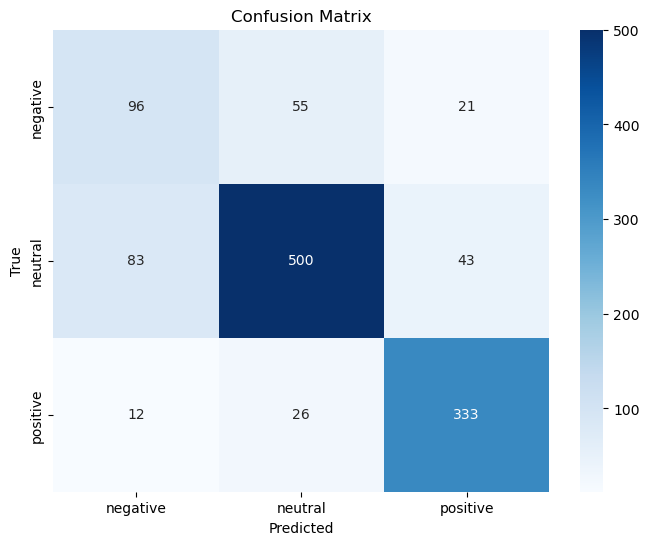

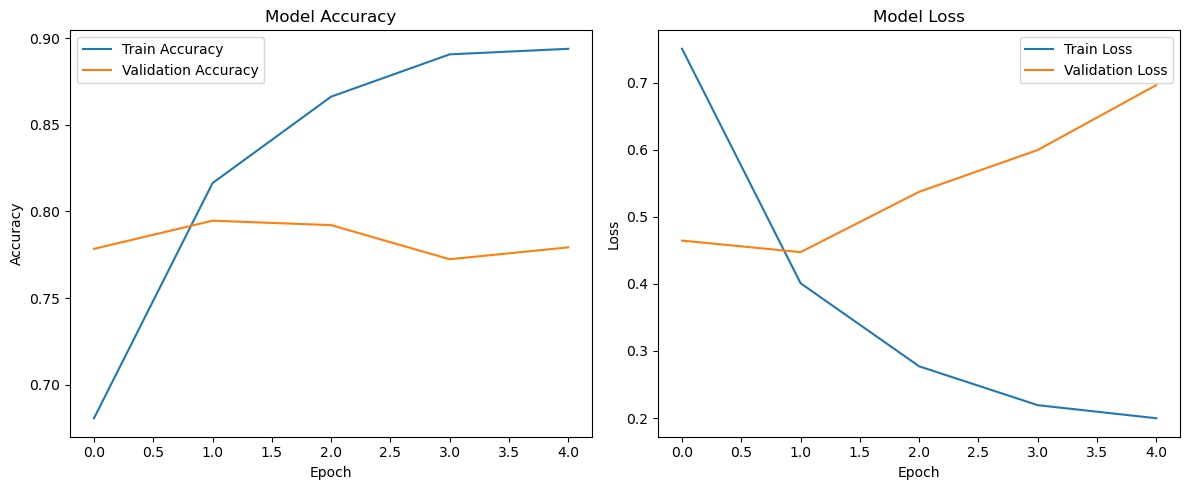

In [3]:
# sentiment_analysis_tensorflow.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import random
import os

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure 'data.csv' has at least two columns: 'Sentence' and 'Sentiment'
df = pd.read_csv("./data.csv")

# Check if necessary columns exist
if not {'Sentence', 'Sentiment'}.issubset(df.columns):
    raise ValueError("Dataset must contain 'Sentence' and 'Sentiment' columns.")

# Inspect unique sentiment labels before encoding
print("Unique sentiment labels before encoding:", df['Sentiment'].unique())

# Encode sentiment labels into integers
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# Verify encoded labels
print("Unique encoded sentiment labels:", np.unique(df['Sentiment']))

# Define maximum sequence length
MAX_LEN = 128

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the sentences
def tokenize_sentences(sentences, tokenizer, max_len):
    input_ids = []
    attention_masks = []
    
    for sent in tqdm(sentences, desc="Tokenizing"):
        encoded = tokenizer(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
            # clean_up_tokenization_spaces=True  # Removed to prevent warning
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return (
        tf.concat(input_ids, axis=0),
        tf.concat(attention_masks, axis=0)
    )

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df['Sentence'].values, tokenizer, MAX_LEN)

# Convert TensorFlow tensors to NumPy arrays
input_ids = input_ids.numpy()
attention_masks = attention_masks.numpy()

# Define labels
labels = df['Sentiment'].values

# Split the data into training and testing sets
X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {X_train_ids.shape[0]}")
print(f"Testing samples: {X_test_ids.shape[0]}")

# -------------------------------
# 3. Model Architecture with Dynamic ContextResonance
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the Enhanced ContextResonance Layer
class DynamicContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(DynamicContextResonance, self).__init__(**kwargs)
        self.dense1 = Dense(hidden_size, activation='relu')
        self.dense2 = Dense(1, activation='sigmoid')  # Outputs resonance score between 0 and 1

    def call(self, inputs):
        # inputs shape: (batch_size, seq_length, hidden_size)
        x = self.dense1(inputs)  # (batch_size, seq_length, hidden_size)
        resonance_scores = self.dense2(x)  # (batch_size, seq_length, 1)
        modulated_inputs = inputs * resonance_scores  # Element-wise multiplication
        return modulated_inputs

    def get_config(self):
        base_config = super(DynamicContextResonance, self).get_config()
        return base_config

# Define the Transformer block with Dynamic ContextResonance
def transformer_block_with_dynamic_context_resonance(bert_model, input_ids, attention_masks, hidden_size):
    # Get BERT outputs
    bert_outputs = bert_model(input_ids, attention_mask=attention_masks)
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
    
    # Apply Dynamic ContextResonance
    resonance_layer = DynamicContextResonance(hidden_size)(sequence_output)
    
    # Process attention_masks for MultiHeadAttention
    # Convert attention_masks from (batch_size, seq_length) to (batch_size, 1, 1, seq_length)
    attention_mask = tf.cast(attention_masks, tf.float32)
    attention_mask = attention_mask[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch_size, 1, 1, seq_length)
    
    # Apply MultiHeadAttention with the processed mask
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=12, key_dim=hidden_size // 12
    )(resonance_layer, resonance_layer, attention_mask=attention_mask)
    
    # Add & Normalize
    attention_output = LayerNormalization(epsilon=1e-6)(resonance_layer + attention_output)
    
    # Feed-Forward Network
    ffn_output = Dense(3072, activation='relu')(attention_output)
    ffn_output = Dense(hidden_size)(ffn_output)
    
    # Add & Normalize
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    return ffn_output

# Build the complete model with Dynamic ContextResonance
def build_model_with_dynamic_resonance(bert_model, hidden_size):
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_masks')
    
    # Get transformer output with Dynamic ContextResonance
    transformer_output = transformer_block_with_dynamic_context_resonance(
        bert_model, input_ids, attention_masks, hidden_size
    )
    
    # Pooling: Take the mean of the token embeddings
    pooled_output = tf.reduce_mean(transformer_output, axis=1)
    
    # Classification head
    dropout = Dropout(0.3)(pooled_output)
    output = Dense(len(label_encoder.classes_), activation='softmax')(dropout)
    
    model = Model(inputs=[input_ids, attention_masks], outputs=output)
    
    return model

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
hidden_size = bert_model.config.hidden_size  # Typically 768 for 'bert-base-uncased'

# Build the model
model = build_model_with_dynamic_resonance(bert_model, hidden_size)

# Summary of the model
model.summary()

# -------------------------------
# 4. Training Setup
# -------------------------------

# Compile the model
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Convert labels to tensors
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train_ids, 'attention_masks': X_train_masks},
    y_train
)).shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_test_ids, 'attention_masks': X_test_masks},
    y_test
)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stop, checkpoint]
)

# -------------------------------
# 5. Evaluation
# -------------------------------

# Load the best saved model
model.load_weights('best_model.h5')

# Predict on the test set
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(y_test, y_pred).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# -------------------------------
# 6. Visualization
# -------------------------------

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# sentiment_analysis_with_spacy_fixed.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from spektral.layers import GCNConv
import networkx as nx
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import random
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure 'data.csv' has at least two columns: 'Sentence' and 'Sentiment'
df = pd.read_csv("./data.csv")

# Check if necessary columns exist
if not {'Sentence', 'Sentiment'}.issubset(df.columns):
    raise ValueError("Dataset must contain 'Sentence' and 'Sentiment' columns.")

# Inspect unique sentiment labels before encoding
print("Unique sentiment labels before encoding:", df['Sentiment'].unique())

# Encode sentiment labels into integers
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# Verify encoded labels
print("Unique encoded sentiment labels:", np.unique(df['Sentiment']))

# Define maximum sequence length
MAX_LEN = 128

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize spaCy's English model
nlp = spacy.load('en_core_web_sm')

def sentence_to_graph_spacy(sentence):
    """
    Converts a sentence into a graph using spaCy's dependency parsing.
    Nodes represent tokens, and edges represent dependencies.
    """
    G = nx.Graph()
    doc = nlp(sentence)
    
    # Add nodes with unique identifiers to handle duplicate tokens
    for token in doc:
        G.add_node(token.i, text=token.text, pos=token.pos_)
    
    # Add edges based on dependency relations
    for token in doc:
        if token.dep_ != 'ROOT':
            G.add_edge(token.head.i, token.i, relation=token.dep_)
    
    return G

def graphs_to_adjacency_spacy(sentences, tokenizer, max_len=128, window_size=2):
    """
    Converts a list of sentences into adjacency matrices.
    Uses dependency parsing via spaCy; falls back to window-based adjacency if parsing fails.
    Pads adjacency matrices to (max_len, max_len).
    """
    adjacency_matrices = []
    
    for sentence in tqdm(sentences, desc="Constructing Adjacency Matrices"):
        try:
            G = sentence_to_graph_spacy(sentence)
            tokens = tokenizer.tokenize(sentence)
            tokens = tokens[:max_len]  # Truncate if necessary
            num_tokens = len(tokens)
            
            # Initialize adjacency matrix with dtype float32
            adj = np.zeros((max_len, max_len), dtype=np.float32)
            
            # Map token indices to adjacency matrix indices
            token_indices = {token.i: idx for idx, token in enumerate(nlp(sentence)[:max_len])}
            
            # Add edges based on dependency parsing
            for edge in G.edges(data=True):
                node1, node2, data = edge
                if node1 in token_indices and node2 in token_indices:
                    idx1 = token_indices[node1]
                    idx2 = token_indices[node2]
                    adj[idx1, idx2] = 1.0
                    adj[idx2, idx1] = 1.0  # Assuming undirected graph
            
            # Check if the graph has at least one edge; if not, use fallback
            if np.sum(adj) == 0:
                raise ValueError("No edges found; using window-based adjacency.")
        
        except Exception as e:
            print(f"Graph construction error for sentence: {sentence}\nReason: {e}\nUsing window-based adjacency.")
            adj = window_based_adjacency([sentence], window_size=window_size, max_len=max_len)[0]
        
        adjacency_matrices.append(adj)
    
    return np.array(adjacency_matrices, dtype=np.float32)

def window_based_adjacency(sentences, window_size=2, max_len=128):
    """
    Creates adjacency matrices based on a sliding window approach.
    Each token is connected to its neighbors within the window size.
    """
    adjacency_matrices = []
    
    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)
        
        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0
        
        adjacency_matrices.append(adj)
    
    return np.array(adjacency_matrices, dtype=np.float32)

def tokenize_sentences(sentences, tokenizer, max_len=128, batch_size=32):
    """
    Tokenizes sentences in batches for efficiency.
    """
    input_ids = []
    attention_masks = []
    
    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
            # clean_up_tokenization_spaces=True  # Removed to prevent warning
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    # Concatenate all batches
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()
    
    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df['Sentence'].values, tokenizer, MAX_LEN, batch_size=32)

# Create adjacency matrices with robust graph construction
adjacency_matrices = graphs_to_adjacency_spacy(df['Sentence'].values, tokenizer, MAX_LEN, window_size=2)

# Define labels
labels = df['Sentiment'].values

# Split the data into training and testing sets
X_train_ids, X_test_ids, X_train_masks, X_test_masks, adjacency_train, adjacency_test, y_train, y_test = train_test_split(
    input_ids, attention_masks, adjacency_matrices, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {X_train_ids.shape[0]}")
print(f"Testing samples: {X_test_ids.shape[0]}")

# -------------------------------
# 3. Model Architecture with GNN and Resonance Score Visualization
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv

# Define the GNN-Based ContextResonance Layer
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.gcn1 = GCNConv(128, activation='relu')  # First GCN layer with 128 units
        self.gcn2 = GCNConv(hidden_size, activation='relu')  # Second GCN layer to match hidden_size
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')  # Resonance scores
    
    def call(self, inputs, adjacency):
        """
        inputs: BERT embeddings (batch_size, seq_length, hidden_size)
        adjacency: Adjacency matrices (batch_size, seq_length, seq_length)
        """
        # Apply GCN layers
        x = self.gcn1([inputs, adjacency])  # (batch_size, seq_length, 128)
        x = self.gcn2([x, adjacency])      # (batch_size, seq_length, hidden_size)
        
        # Compute resonance scores
        resonance_scores = self.dense(x)    # (batch_size, seq_length, 1)
        resonance_scores = tf.nn.sigmoid(resonance_scores)  # Normalize between 0 and 1
        
        # Modulate inputs with resonance scores
        modulated_inputs = inputs * resonance_scores  # Element-wise multiplication
        
        return modulated_inputs, resonance_scores  # Return scores for visualization
    
    def get_config(self):
        base_config = super(GNNContextResonance, self).get_config()
        return base_config

# Define the complete model with GNNContextResonance and custom loss
def build_model_with_gnn(bert_model, hidden_size, max_len=128):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')
    
    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
    
    # Apply GNN-Based ContextResonance
    gnn_resonance_layer = GNNContextResonance(hidden_size)
    transformer_output, resonance_scores = gnn_resonance_layer(sequence_output, adjacency)
    
    # Continue with Transformer Block (Multi-Head Attention + FFN)
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=12, key_dim=hidden_size // 12
    )(transformer_output, transformer_output, attention_mask=None)  # Using already modulated embeddings
    
    # Add & Normalize
    attention_output = LayerNormalization(epsilon=1e-6)(transformer_output + attention_output)
    
    # Feed-Forward Network
    ffn_output = Dense(3072, activation='relu')(attention_output)
    ffn_output = Dense(hidden_size)(ffn_output)
    
    # Add & Normalize
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    # Pooling: Take the mean of the token embeddings
    pooled_output = GlobalAveragePooling1D()(ffn_output)
    
    # Classification Head
    dropout = Dropout(0.3)(pooled_output)
    output = Dense(len(label_encoder.classes_), activation='softmax', name='sentiment_output')(dropout)
    
    # Define the Model
    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[output, resonance_scores]  # Output resonance scores for visualization
    )
    
    return model

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
hidden_size = bert_model.config.hidden_size  # Typically 768 for 'bert-base-uncased'

# Build the model
model = build_model_with_gnn(bert_model, hidden_size, max_len=MAX_LEN)

# Summary of the model
model.summary()

# -------------------------------
# 4. Defining the Custom Loss Function
# -------------------------------

# Define the optimizer
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

@tf.function
def train_step(input_ids, attention_masks, adjacency, labels):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions, resonance_scores = model([input_ids, attention_masks, adjacency], training=True)
        
        # Compute standard loss
        cce_loss = loss_fn(labels, predictions)
        
        # Compute smoothness loss
        resonance_scores = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
        resonance_diff = resonance_scores[:, :, tf.newaxis] - resonance_scores[:, tf.newaxis, :]
        squared_diff = tf.square(resonance_diff)
        smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])
        smoothness_loss = tf.reduce_mean(smoothness_loss)
        
        # Total loss
        alpha = 0.1
        total_loss = cce_loss + alpha * smoothness_loss
    
    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)
    
    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return total_loss, cce_loss, smoothness_loss

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels):
    # Forward pass
    predictions, resonance_scores = model([input_ids, attention_masks, adjacency], training=False)
    
    # Compute standard loss
    cce_loss = loss_fn(labels, predictions)
    
    # Compute smoothness loss
    resonance_scores = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
    resonance_diff = resonance_scores[:, :, tf.newaxis] - resonance_scores[:, tf.newaxis, :]
    squared_diff = tf.square(resonance_diff)
    smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])
    smoothness_loss = tf.reduce_mean(smoothness_loss)
    
    # Total loss
    alpha = 0.1
    total_loss = cce_loss + alpha * smoothness_loss
    
    return total_loss, cce_loss, smoothness_loss

# -------------------------------
# 5. Training the Model
# -------------------------------

# Define training parameters
epochs = 10
batch_size = 32
alpha = 0.1  # Weight for smoothness loss

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks,
        'adjacency': adjacency_train
    },
    y_train
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks,
        'adjacency': adjacency_test
    },
    y_test
)).batch(batch_size)

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    
    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_avg = tf.keras.metrics.Mean()
    smoothness_loss_avg = tf.keras.metrics.Mean()
    
    for step, (batch_inputs, batch_labels) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels = batch_labels
        
        total_loss, cce_loss, smoothness_loss = train_step(input_ids, attention_masks, adjacency, labels)
        
        total_loss_avg.update_state(total_loss)
        cce_loss_avg.update_state(cce_loss)
        smoothness_loss_avg.update_state(smoothness_loss)
        
        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, CCE Loss = {cce_loss_avg.result():.4f}, Smoothness Loss = {smoothness_loss_avg.result():.4f}")
    
    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    
    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_avg = tf.keras.metrics.Mean()
    val_smoothness_loss_avg = tf.keras.metrics.Mean()
    
    for batch_inputs, batch_labels in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels = batch_labels
        
        total_loss, cce_loss, smoothness_loss = test_step(input_ids, attention_masks, adjacency, labels)
        
        val_loss_avg.update_state(total_loss)
        val_cce_loss_avg.update_state(cce_loss)
        val_smoothness_loss_avg.update_state(smoothness_loss)
    
    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}, CCE Loss: {val_cce_loss_avg.result():.4f}, Smoothness Loss: {val_smoothness_loss_avg.result():.4f}")

# -------------------------------
# 6. Model Evaluation and Resonance Score Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def decode_tokens(input_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return tokens

def visualize_resonance_scores(tokens, resonance_scores, predicted_label, label_encoder):
    """
    Plots resonance scores for each token in the sentence.
    """
    plt.figure(figsize=(12, 2))
    plt.bar(range(len(tokens)), resonance_scores, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(f"Predicted Sentiment: {label_encoder.inverse_transform([predicted_label])[0]}")
    plt.xlabel("Tokens")
    plt.ylabel("Resonance Score")
    plt.tight_layout()
    plt.show()

# Predict on the test set
all_predictions = []
all_labels = []
all_resonance_scores = []

for batch_inputs, batch_labels in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']
    
    predictions, resonance_scores = model.predict([input_ids, attention_masks, adjacency])
    predicted_labels = np.argmax(predictions, axis=1)
    
    all_predictions.extend(predicted_labels)
    all_labels.extend(batch_labels.numpy())
    all_resonance_scores.extend(resonance_scores.numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(all_labels, all_predictions).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualizing Resonance Scores for a Sample Sentence
# Select a sample from the test set
sample_index = 0  # Change as needed
sample_input_ids = X_test_ids[sample_index:sample_index+1]
sample_attention_masks = X_test_masks[sample_index:sample_index+1]
sample_adjacency = adjacency_test[sample_index:sample_index+1]
sample_label = y_test[sample_index]

# Predict sentiment and get resonance scores
predictions, resonance_scores = model.predict([sample_input_ids, sample_attention_masks, sample_adjacency])
predicted_label = np.argmax(predictions, axis=1)[0]

# Decode tokens
tokens = decode_tokens(sample_input_ids[0], tokenizer)

# Extract and normalize resonance scores
resonance = resonance_scores[0].squeeze()[:len(tokens)]
# Ensure resonance is float32 to match plotting
resonance_normalized = (resonance - np.min(resonance)) / (np.max(resonance) - np.min(resonance) + 1e-8)
resonance_normalized = resonance_normalized.astype(np.float32)

# Visualize resonance scores
visualize_resonance_scores(
    tokens=tokens,
    resonance_scores=resonance_normalized,
    predicted_label=predicted_label,
    label_encoder=label_encoder
)


f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Enabled memory growth for 1 GPU(s).
Unique sentiment labels before encoding: ['positive' 'negative' 'neutral']
Unique encoded sentiment labels: [0 1 2]


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Constructing Adjacency Matrices: 100%|██████████| 5842/5842 [01:22<00:00, 70.80it/s]


Training samples: 4673
Testing samples: 1169


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Enabled memory growth for 1 GPU(s).
Unique sentiment labels before encoding: ['positive' 'negative' 'neutral']
Unique encoded sentiment labels: [0 1 2]


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Constructing Adjacency Matrices: 100%|██████████| 5842/5842 [01:20<00:00, 72.84it/s]


Training samples: 4673
Testing samples: 1169


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

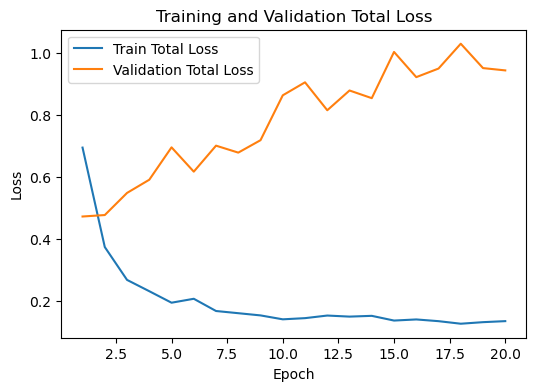

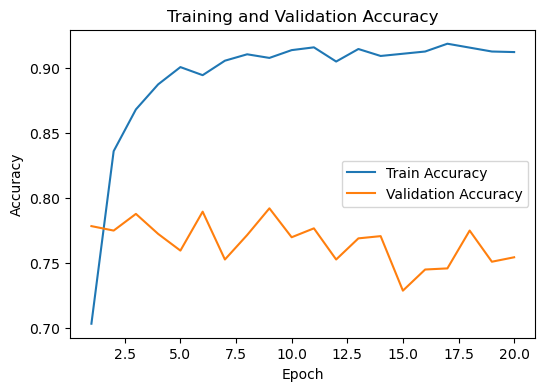

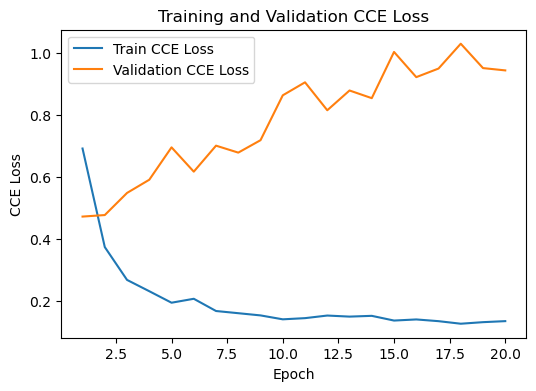

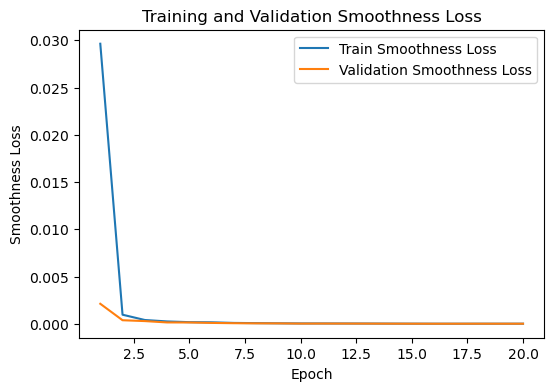

1/1 [==============================] - 3s 3s/step


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [1]:
# sentiment_analysis_with_spacy_fixed.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from spektral.layers import GCNConv
import networkx as nx
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import random
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure 'data.csv' has at least two columns: 'Sentence' and 'Sentiment'
df = pd.read_csv("./data.csv")

# Check if necessary columns exist
if not {'Sentence', 'Sentiment'}.issubset(df.columns):
    raise ValueError("Dataset must contain 'Sentence' and 'Sentiment' columns.")

# Inspect unique sentiment labels before encoding
print("Unique sentiment labels before encoding:", df['Sentiment'].unique())

# Encode sentiment labels into integers
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# Verify encoded labels
print("Unique encoded sentiment labels:", np.unique(df['Sentiment']))

# Define maximum sequence length
MAX_LEN = 128

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize spaCy's English model
nlp = spacy.load('en_core_web_sm')

def sentence_to_graph_spacy(sentence):
    """
    Converts a sentence into a graph using spaCy's dependency parsing.
    Nodes represent tokens, and edges represent dependencies.
    """
    G = nx.Graph()
    doc = nlp(sentence)
    
    # Add nodes with unique identifiers to handle duplicate tokens
    for token in doc:
        G.add_node(token.i, text=token.text, pos=token.pos_)
    
    # Add edges based on dependency relations
    for token in doc:
        if token.dep_ != 'ROOT':
            G.add_edge(token.head.i, token.i, relation=token.dep_)
    
    return G

def graphs_to_adjacency_spacy(sentences, tokenizer, max_len=128, window_size=2):
    """
    Converts a list of sentences into adjacency matrices.
    Uses dependency parsing via spaCy; falls back to window-based adjacency if parsing fails.
    Pads adjacency matrices to (max_len, max_len).
    """
    adjacency_matrices = []
    
    for sentence in tqdm(sentences, desc="Constructing Adjacency Matrices"):
        try:
            G = sentence_to_graph_spacy(sentence)
            tokens = tokenizer.tokenize(sentence)
            tokens = tokens[:max_len]  # Truncate if necessary
            num_tokens = len(tokens)
            
            # Initialize adjacency matrix with dtype float32
            adj = np.zeros((max_len, max_len), dtype=np.float32)
            
            # Map token indices to adjacency matrix indices
            token_indices = {token.i: idx for idx, token in enumerate(nlp(sentence)[:max_len])}
            
            # Add edges based on dependency parsing
            for edge in G.edges(data=True):
                node1, node2, data = edge
                if node1 in token_indices and node2 in token_indices:
                    idx1 = token_indices[node1]
                    idx2 = token_indices[node2]
                    adj[idx1, idx2] = 1.0
                    adj[idx2, idx1] = 1.0  # Assuming undirected graph
            
            # Check if the graph has at least one edge; if not, use fallback
            if np.sum(adj) == 0:
                raise ValueError("No edges found; using window-based adjacency.")
        
        except Exception as e:
            print(f"Graph construction error for sentence: {sentence}\nReason: {e}\nUsing window-based adjacency.")
            adj = window_based_adjacency([sentence], window_size=window_size, max_len=max_len)[0]
        
        adjacency_matrices.append(adj)
    
    return np.array(adjacency_matrices, dtype=np.float32)

def window_based_adjacency(sentences, window_size=2, max_len=128):
    """
    Creates adjacency matrices based on a sliding window approach.
    Each token is connected to its neighbors within the window size.
    """
    adjacency_matrices = []
    
    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)
        
        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0
        
        adjacency_matrices.append(adj)
    
    return np.array(adjacency_matrices, dtype=np.float32)

def tokenize_sentences(sentences, tokenizer, max_len=128, batch_size=32):
    """
    Tokenizes sentences in batches for efficiency.
    """
    input_ids = []
    attention_masks = []
    
    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
            # clean_up_tokenization_spaces=True  # Removed to prevent warning
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    # Concatenate all batches
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()
    
    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df['Sentence'].values, tokenizer, MAX_LEN, batch_size=32)

# Create adjacency matrices with robust graph construction
adjacency_matrices = graphs_to_adjacency_spacy(df['Sentence'].values, tokenizer, MAX_LEN, window_size=2)

# Define labels
labels = df['Sentiment'].values

# Split the data into training and testing sets
X_train_ids, X_test_ids, X_train_masks, X_test_masks, adjacency_train, adjacency_test, y_train, y_test = train_test_split(
    input_ids, attention_masks, adjacency_matrices, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {X_train_ids.shape[0]}")
print(f"Testing samples: {X_test_ids.shape[0]}")

# -------------------------------
# 3. Model Architecture with GNN and Resonance Score Visualization
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv

# Define the GNN-Based ContextResonance Layer
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.gcn1 = GCNConv(128, activation='relu')  # First GCN layer with 128 units
        self.gcn2 = GCNConv(hidden_size, activation='relu')  # Second GCN layer to match hidden_size
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')  # Resonance scores
    
    def call(self, inputs, adjacency):
        """
        inputs: BERT embeddings (batch_size, seq_length, hidden_size)
        adjacency: Adjacency matrices (batch_size, seq_length, seq_length)
        """
        # Apply GCN layers
        x = self.gcn1([inputs, adjacency])  # (batch_size, seq_length, 128)
        x = self.gcn2([x, adjacency])      # (batch_size, seq_length, hidden_size)
        
        # Compute resonance scores
        resonance_scores = self.dense(x)    # (batch_size, seq_length, 1)
        resonance_scores = tf.nn.sigmoid(resonance_scores)  # Normalize between 0 and 1
        
        # Modulate inputs with resonance scores
        modulated_inputs = inputs * resonance_scores  # Element-wise multiplication
        
        return modulated_inputs, resonance_scores  # Return scores for visualization
    
    def get_config(self):
        base_config = super(GNNContextResonance, self).get_config()
        return base_config

# Define the complete model with GNNContextResonance and custom loss
def build_model_with_gnn(bert_model, hidden_size, max_len=128):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')
    
    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
    
    # Apply GNN-Based ContextResonance
    gnn_resonance_layer = GNNContextResonance(hidden_size)
    transformer_output, resonance_scores = gnn_resonance_layer(sequence_output, adjacency)
    
    # Continue with Transformer Block (Multi-Head Attention + FFN)
    attention_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=12, key_dim=hidden_size // 12, name='multi_head_attention'
    )
    attention_output, attention_scores = attention_layer(
        query=transformer_output,
        value=transformer_output,
        key=transformer_output,
        return_attention_scores=True
    )  # Using already modulated embeddings
    
    # Add & Normalize
    attention_output = LayerNormalization(epsilon=1e-6)(transformer_output + attention_output)
    
    # Feed-Forward Network
    ffn_output = Dense(3072, activation='relu')(attention_output)
    ffn_output = Dense(hidden_size)(ffn_output)
    
    # Add & Normalize
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    # Pooling: Take the mean of the token embeddings
    pooled_output = GlobalAveragePooling1D()(ffn_output)
    
    # Classification Head
    dropout = Dropout(0.3)(pooled_output)
    output = Dense(len(label_encoder.classes_), activation='softmax', name='sentiment_output')(dropout)
    
    # Define the Model
    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[output, resonance_scores, attention_scores]  # Output resonance scores and attention scores for visualization
    )
    
    return model

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
hidden_size = bert_model.config.hidden_size  # Typically 768 for 'bert-base-uncased'

# Build the model
model = build_model_with_gnn(bert_model, hidden_size, max_len=MAX_LEN)

# Summary of the model
model.summary()

# -------------------------------
# 4. Defining the Custom Loss Function and Metrics
# -------------------------------

# Define the optimizer
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Define metrics
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

@tf.function
def train_step(input_ids, attention_masks, adjacency, labels):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions, resonance_scores, _ = model([input_ids, attention_masks, adjacency], training=True)
        
        # Compute standard loss
        cce_loss = loss_fn(labels, predictions)
        
        # Compute smoothness loss
        resonance_scores = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
        resonance_diff = resonance_scores[:, :, tf.newaxis] - resonance_scores[:, tf.newaxis, :]
        squared_diff = tf.square(resonance_diff)
        smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])
        smoothness_loss = tf.reduce_mean(smoothness_loss)
        
        # Total loss
        alpha = 0.1
        total_loss = cce_loss + alpha * smoothness_loss
    
    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)
    
    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Update metrics
    train_accuracy.update_state(labels, predictions)
    
    return total_loss, cce_loss, smoothness_loss

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels):
    # Forward pass
    predictions, resonance_scores, _ = model([input_ids, attention_masks, adjacency], training=False)
    
    # Compute standard loss
    cce_loss = loss_fn(labels, predictions)
    
    # Compute smoothness loss
    resonance_scores = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
    resonance_diff = resonance_scores[:, :, tf.newaxis] - resonance_scores[:, tf.newaxis, :]
    squared_diff = tf.square(resonance_diff)
    smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])
    smoothness_loss = tf.reduce_mean(smoothness_loss)
    
    # Total loss
    alpha = 0.1
    total_loss = cce_loss + alpha * smoothness_loss
    
    # Update metrics
    val_accuracy.update_state(labels, predictions)
    
    return total_loss, cce_loss, smoothness_loss

# -------------------------------
# 5. Training the Model
# -------------------------------

# Define training parameters
epochs = 20
batch_size = 16
alpha = 0.1  # Weight for smoothness loss

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks,
        'adjacency': adjacency_train
    },
    y_train
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks,
        'adjacency': adjacency_test
    },
    y_test
)).batch(batch_size)

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss': [],
    'train_smoothness_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_cce_loss': [],
    'val_smoothness_loss': [],
    'val_accuracy': []
}

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    
    # Reset metrics at the start of each epoch
    train_accuracy.reset_states()
    val_accuracy.reset_states()
    
    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_avg = tf.keras.metrics.Mean()
    smoothness_loss_avg = tf.keras.metrics.Mean()
    
    for step, (batch_inputs, batch_labels) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels = batch_labels
        
        total_loss, cce_loss, smoothness_loss = train_step(input_ids, attention_masks, adjacency, labels)
        
        total_loss_avg.update_state(total_loss)
        cce_loss_avg.update_state(cce_loss)
        smoothness_loss_avg.update_state(smoothness_loss)
        
        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, CCE Loss = {cce_loss_avg.result():.4f}, Smoothness Loss = {smoothness_loss_avg.result():.4f}, Train Accuracy = {train_accuracy.result():.4f}")
    
    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss'].append(cce_loss_avg.result().numpy())
    history['train_smoothness_loss'].append(smoothness_loss_avg.result().numpy())
    history['train_accuracy'].append(train_accuracy.result().numpy())
    
    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss: {cce_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Smoothness Loss: {smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy: {train_accuracy.result():.4f}")
    
    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_avg = tf.keras.metrics.Mean()
    val_smoothness_loss_avg = tf.keras.metrics.Mean()
    
    for batch_inputs, batch_labels in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels = batch_labels
        
        total_loss, cce_loss, smoothness_loss = test_step(input_ids, attention_masks, adjacency, labels)
        
        val_loss_avg.update_state(total_loss)
        val_cce_loss_avg.update_state(cce_loss)
        val_smoothness_loss_avg.update_state(smoothness_loss)
    
    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss'].append(val_cce_loss_avg.result().numpy())
    history['val_smoothness_loss'].append(val_smoothness_loss_avg.result().numpy())
    history['val_accuracy'].append(val_accuracy.result().numpy())
    
    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss: {val_cce_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Smoothness Loss: {val_smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy: {val_accuracy.result():.4f}")

# -------------------------------
# 6. Model Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def decode_tokens(input_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return tokens

def visualize_resonance_scores(tokens, resonance_scores, predicted_label, label_encoder):
    """
    Plots resonance scores for each token in the sentence.
    """
    plt.figure(figsize=(6, 2))
    plt.bar(range(len(tokens)), resonance_scores, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(f"Predicted Sentiment: {label_encoder.inverse_transform([predicted_label])[0]}")
    plt.xlabel("Tokens")
    plt.ylabel("Resonance Score")
    plt.tight_layout()
    plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs+1), history['train_loss'], label='Train Total Loss')
plt.plot(range(1, epochs+1), history['val_loss'], label='Validation Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Total Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs+1), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(1, epochs+1), history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation CCE Loss
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs+1), history['train_cce_loss'], label='Train CCE Loss')
plt.plot(range(1, epochs+1), history['val_cce_loss'], label='Validation CCE Loss')
plt.xlabel('Epoch')
plt.ylabel('CCE Loss')
plt.title('Training and Validation CCE Loss')
plt.legend()
plt.show()

# Plot Training and Validation Smoothness Loss
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs+1), history['train_smoothness_loss'], label='Train Smoothness Loss')
plt.plot(range(1, epochs+1), history['val_smoothness_loss'], label='Validation Smoothness Loss')
plt.xlabel('Epoch')
plt.ylabel('Smoothness Loss')
plt.title('Training and Validation Smoothness Loss')
plt.legend()
plt.show()

# -------------------------------
# 7. Detailed Model Evaluation
# -------------------------------

# Predict on the test set
all_predictions = []
all_labels = []
all_resonance_scores = []

for batch_inputs, batch_labels in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']
    
    predictions, resonance_scores, _ = model.predict([input_ids, attention_masks, adjacency])
    predicted_labels = np.argmax(predictions, axis=1)
    
    all_predictions.extend(predicted_labels)
    all_labels.extend(batch_labels.numpy())
    all_resonance_scores.extend(resonance_scores.numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='macro')
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Macro F1 Score: {f1:.4f}")
print(f"Test Macro Precision: {precision:.4f}")
print(f"Test Macro Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(all_labels, all_predictions).numpy()
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualizing Resonance Scores for a Sample Sentence
# Select a sample from the test set
sample_index = 0  # Change as needed
sample_input_ids = X_test_ids[sample_index:sample_index+1]
sample_attention_masks = X_test_masks[sample_index:sample_index+1]
sample_adjacency = adjacency_test[sample_index:sample_index+1]
sample_label = y_test[sample_index]

# Predict sentiment and get resonance scores
predictions, resonance_scores, attention_scores = model.predict([sample_input_ids, sample_attention_masks, sample_adjacency])
predicted_label = np.argmax(predictions, axis=1)[0]

# Decode tokens
tokens = decode_tokens(sample_input_ids[0], tokenizer)

# Extract and normalize resonance scores
resonance = resonance_scores[0].squeeze()[:len(tokens)]
# Ensure resonance is float32 to match plotting
resonance_normalized = (resonance - np.min(resonance)) / (np.max(resonance) - np.min(resonance) + 1e-8)
resonance_normalized = resonance_normalized.astype(np.float32)

# Visualize resonance scores
visualize_resonance_scores(
    tokens=tokens,
    resonance_scores=resonance_normalized,
    predicted_label=predicted_label,
    label_encoder=label_encoder
)

# Optional: Visualize Attention Scores for the Sample Sentence
def visualize_attention_scores(tokens, attention_scores, head=0):
    """
    Plots attention scores for a specific head in the Multi-Head Attention layer.
    """
    # Select the desired head
    attention = attention_scores[head].numpy()  # Shape: (batch_size, seq_length, seq_length)
    attention = attention[0]  # Select the first (and only) sample in the batch
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Attention Scores - Head {head+1}')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Visualize attention scores for the first head
visualize_attention_scores(tokens, attention_scores, head=0)

# If you want to visualize multiple heads, you can loop over them
# for head in range(attention_scores.shape[-1]):
#     visualize_attention_scores(tokens, attention_scores, head=head)


1/1 [==============================] - 0s 53ms/step
Test Accuracy: 0.7545
Test Macro F1 Score: 0.6991
Test Macro Precision: 0.6928
Test Macro Recall: 0.7108
Class: negative
  Precision: 0.4083
  Recall:    0.5174
  F1-Score:  0.4564

Class: neutral
  Precision: 0.8293
  Recall:    0.7604
  F1-Score:  0.7933

Class: positive
  Precision: 0.8408
  Recall:    0.8544
  F1-Score:  0.8476



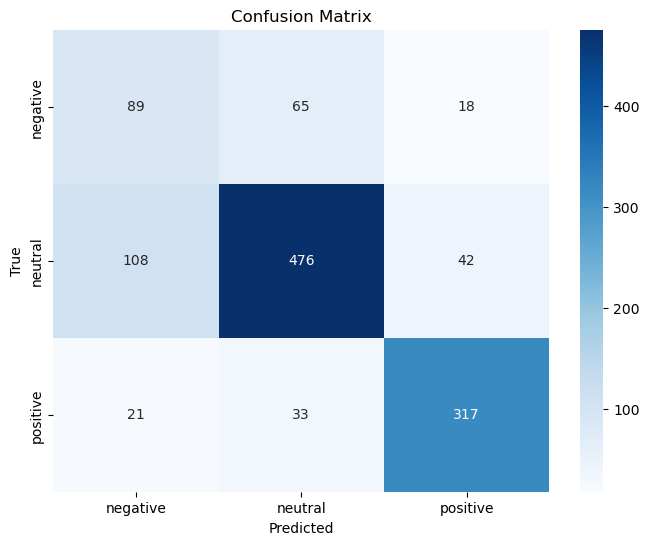

1/1 [==============================] - 0s 57ms/step


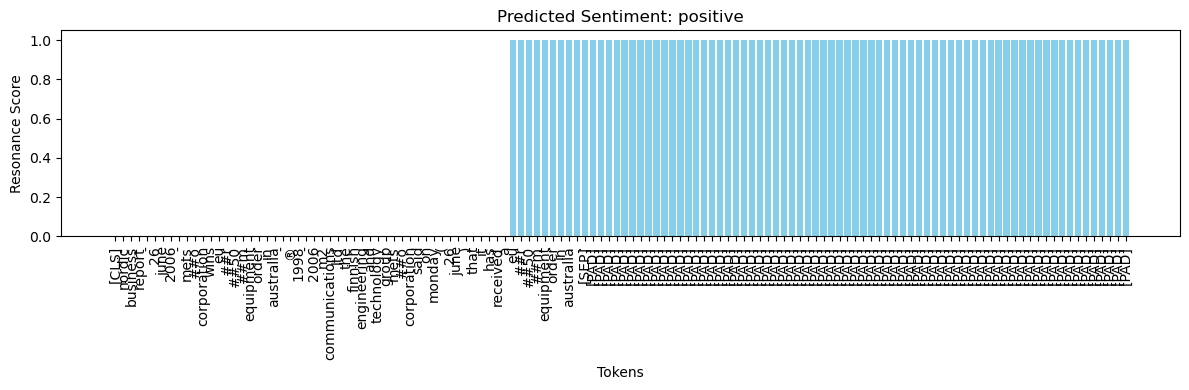

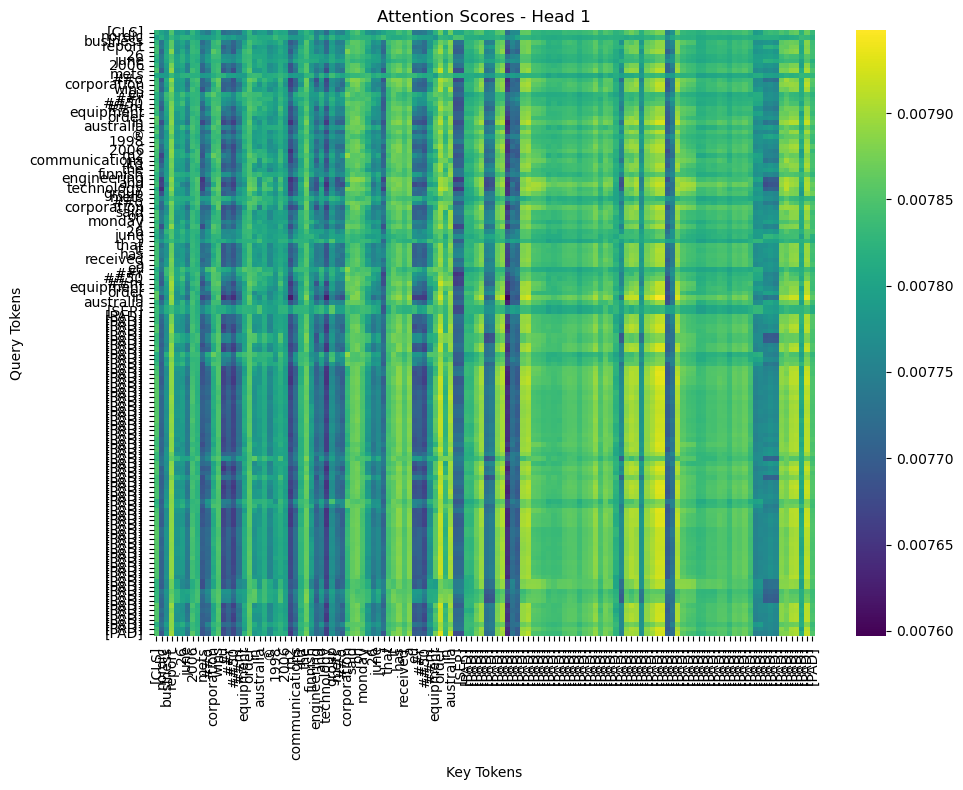

In [4]:
# -------------------------------
# 7. Detailed Model Evaluation
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def decode_tokens(input_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return tokens

def visualize_resonance_scores(tokens, resonance_scores, predicted_label, label_encoder):
    """
    Plots resonance scores for each token in the sentence.
    """
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(tokens)), resonance_scores, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(f"Predicted Sentiment: {label_encoder.inverse_transform([predicted_label])[0]}")
    plt.xlabel("Tokens")
    plt.ylabel("Resonance Score")
    plt.tight_layout()
    plt.show()

def visualize_attention_scores(tokens, attention_scores, head=0):
    """
    Plots attention scores for a specific head in the Multi-Head Attention layer.
    """
    # Select the desired head
    attention = attention_scores[0][head]  # Shape: (seq_length, seq_length)
    # No need to call .numpy() since attention_scores is already a NumPy array
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Attention Scores - Head {head+1}')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Predict on the test set
all_predictions = []
all_labels = []
all_resonance_scores = []

for batch_inputs, batch_labels in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']
    
    predictions, resonance_scores, attention_scores = model.predict([input_ids, attention_masks, adjacency])
    predicted_labels = np.argmax(predictions, axis=1)
    
    all_predictions.extend(predicted_labels)
    
    # Handle batch_labels correctly
    if isinstance(batch_labels, tf.Tensor):
        all_labels.extend(batch_labels.numpy())
    else:
        all_labels.extend(batch_labels)
    
    # Remove .numpy() as resonance_scores is already a NumPy array
    all_resonance_scores.extend(resonance_scores)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='macro')
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Macro F1 Score: {f1:.4f}")
print(f"Test Macro Precision: {precision:.4f}")
print(f"Test Macro Recall: {recall:.4f}")

# Per-class metrics
precision_per_class = precision_score(all_labels, all_predictions, average=None)
recall_per_class = recall_score(all_labels, all_predictions, average=None)
f1_per_class = f1_score(all_labels, all_predictions, average=None)

for idx, class_label in enumerate(label_encoder.classes_):
    print(f"Class: {class_label}")
    print(f"  Precision: {precision_per_class[idx]:.4f}")
    print(f"  Recall:    {recall_per_class[idx]:.4f}")
    print(f"  F1-Score:  {f1_per_class[idx]:.4f}\n")

# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(all_labels, all_predictions).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualizing Resonance Scores for a Sample Sentence
# Select a sample from the test set
sample_index = 0  # Change as needed
sample_input_ids = X_test_ids[sample_index:sample_index+1]
sample_attention_masks = X_test_masks[sample_index:sample_index+1]
sample_adjacency = adjacency_test[sample_index:sample_index+1]
sample_label = y_test[sample_index]

# Predict sentiment and get resonance scores
predictions, resonance_scores, attention_scores = model.predict([sample_input_ids, sample_attention_masks, sample_adjacency])
predicted_label = np.argmax(predictions, axis=1)[0]

# Decode tokens
tokens = decode_tokens(sample_input_ids[0], tokenizer)

# Extract and normalize resonance scores
resonance = resonance_scores[0].squeeze()[:len(tokens)]
# Ensure resonance is float32 to match plotting
resonance_normalized = (resonance - np.min(resonance)) / (np.max(resonance) - np.min(resonance) + 1e-8)
resonance_normalized = resonance_normalized.astype(np.float32)

# Visualize resonance scores
visualize_resonance_scores(
    tokens=tokens,
    resonance_scores=resonance_normalized,
    predicted_label=predicted_label,
    label_encoder=label_encoder
)

# Visualize attention scores for the first head
visualize_attention_scores(tokens, attention_scores, head=0)


In [6]:
# sentiment_analysis_with_spacy_fixed.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from spektral.layers import GCNConv
import networkx as nx
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import random
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight  # <-- Added import for class weights

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure 'data.csv' has at least two columns: 'Sentence' and 'Sentiment'
df = pd.read_csv("./data.csv")

# Check if necessary columns exist
if not {'Sentence', 'Sentiment'}.issubset(df.columns):
    raise ValueError("Dataset must contain 'Sentence' and 'Sentiment' columns.")

# Inspect unique sentiment labels before encoding
print("Unique sentiment labels before encoding:", df['Sentiment'].unique())

# Encode sentiment labels into integers
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# Verify encoded labels
print("Unique encoded sentiment labels:", np.unique(df['Sentiment']))

# Define maximum sequence length
MAX_LEN = 50  # Increased from 20 to 50 for better coverage

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize spaCy's English model
nlp = spacy.load('en_core_web_sm')

def sentence_to_graph_spacy(sentence):
    """
    Converts a sentence into a graph using spaCy's dependency parsing.
    Nodes represent tokens, and edges represent dependencies.
    """
    G = nx.Graph()
    doc = nlp(sentence)
    
    # Add nodes with unique identifiers to handle duplicate tokens
    for token in doc:
        G.add_node(token.i, text=token.text, pos=token.pos_)
    
    # Add edges based on dependency relations
    for token in doc:
        if token.dep_ != 'ROOT':
            G.add_edge(token.head.i, token.i, relation=token.dep_)
    
    return G

def graphs_to_adjacency_spacy(sentences, tokenizer, max_len=50, window_size=2):
    """
    Converts a list of sentences into adjacency matrices.
    Uses dependency parsing via spaCy; falls back to window-based adjacency if parsing fails.
    Pads adjacency matrices to (max_len, max_len).
    """
    adjacency_matrices = []
    
    for sentence in tqdm(sentences, desc="Constructing Adjacency Matrices"):
        try:
            G = sentence_to_graph_spacy(sentence)
            tokens = tokenizer.tokenize(sentence)
            tokens = tokens[:max_len]  # Truncate if necessary
            num_tokens = len(tokens)
            
            # Initialize adjacency matrix with dtype float32
            adj = np.zeros((max_len, max_len), dtype=np.float32)
            
            # Map token indices to adjacency matrix indices
            token_indices = {token.i: idx for idx, token in enumerate(nlp(sentence)[:max_len])}
            
            # Add edges based on dependency parsing
            for edge in G.edges(data=True):
                node1, node2, data = edge
                if node1 in token_indices and node2 in token_indices:
                    idx1 = token_indices[node1]
                    idx2 = token_indices[node2]
                    adj[idx1, idx2] = 1.0
                    adj[idx2, idx1] = 1.0  # Assuming undirected graph
            
            # Check if the graph has at least one edge; if not, use fallback
            if np.sum(adj) == 0:
                raise ValueError("No edges found; using window-based adjacency.")
        
        except Exception as e:
            print(f"Graph construction error for sentence: {sentence}\nReason: {e}\nUsing window-based adjacency.")
            adj = window_based_adjacency([sentence], window_size=window_size, max_len=max_len)[0]
        
        adjacency_matrices.append(adj)
    
    return np.array(adjacency_matrices, dtype=np.float32)

def window_based_adjacency(sentences, window_size=2, max_len=128):
    """
    Creates adjacency matrices based on a sliding window approach.
    Each token is connected to its neighbors within the window size.
    """
    adjacency_matrices = []
    
    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)
        
        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0
        
        adjacency_matrices.append(adj)
    
    return np.array(adjacency_matrices, dtype=np.float32)

def tokenize_sentences(sentences, tokenizer, max_len=128, batch_size=32):
    """
    Tokenizes sentences in batches for efficiency.
    """
    input_ids = []
    attention_masks = []
    
    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
            # clean_up_tokenization_spaces=True  # Removed to prevent warning
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    # Concatenate all batches
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()
    
    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df['Sentence'].values, tokenizer, MAX_LEN, batch_size=32)

# Create adjacency matrices with robust graph construction
adjacency_matrices = graphs_to_adjacency_spacy(df['Sentence'].values, tokenizer, MAX_LEN, window_size=2)

# Define labels
labels = df['Sentiment'].values

# Split the data into training and testing sets
X_train_ids, X_test_ids, X_train_masks, X_test_masks, adjacency_train, adjacency_test, y_train, y_test = train_test_split(
    input_ids, attention_masks, adjacency_matrices, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {X_train_ids.shape[0]}")
print(f"Testing samples: {X_test_ids.shape[0]}")

# -------------------------------
# 3. Model Architecture with GNN and Resonance Score Visualization
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv

# Define the GNN-Based ContextResonance Layer
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.gcn1 = GCNConv(128, activation='relu')  # First GCN layer with 128 units
        self.gcn2 = GCNConv(hidden_size, activation='relu')  # Second GCN layer to match hidden_size
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')  # Resonance scores
    
    def call(self, inputs, adjacency):
        """
        inputs: BERT embeddings (batch_size, seq_length, hidden_size)
        adjacency: Adjacency matrices (batch_size, seq_length, seq_length)
        """
        # Apply GCN layers
        x = self.gcn1([inputs, adjacency])  # (batch_size, seq_length, 128)
        x = self.gcn2([x, adjacency])      # (batch_size, seq_length, hidden_size)
        
        # Compute resonance scores
        resonance_scores = self.dense(x)    # (batch_size, seq_length, 1)
        resonance_scores = tf.nn.sigmoid(resonance_scores)  # Normalize between 0 and 1
        
        # Modulate inputs with resonance scores
        modulated_inputs = inputs * resonance_scores  # Element-wise multiplication
        
        return modulated_inputs, resonance_scores  # Return scores for visualization
    
    def get_config(self):
        base_config = super(GNNContextResonance, self).get_config()
        return base_config

# Define the complete model with GNNContextResonance and custom loss
def build_model_with_gnn(bert_model, hidden_size, max_len=128):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')
    
    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
    
    # Apply GNN-Based ContextResonance
    gnn_resonance_layer = GNNContextResonance(hidden_size)
    transformer_output, resonance_scores = gnn_resonance_layer(sequence_output, adjacency)
    
    # Continue with Transformer Block (Multi-Head Attention + FFN)
    attention_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=12, key_dim=hidden_size // 12, name='multi_head_attention'
    )
    attention_output, attention_scores = attention_layer(
        query=transformer_output,
        value=transformer_output,
        key=transformer_output,
        return_attention_scores=True
    )  # Using already modulated embeddings
    
    # Add & Normalize
    attention_output = LayerNormalization(epsilon=1e-6)(transformer_output + attention_output)
    
    # Feed-Forward Network
    ffn_output = Dense(3072, activation='relu')(attention_output)
    ffn_output = Dense(hidden_size)(ffn_output)
    
    # Add & Normalize
    ffn_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    # Pooling: Take the mean of the token embeddings
    pooled_output = GlobalAveragePooling1D()(ffn_output)
    
    # Classification Head
    dropout = Dropout(0.3)(pooled_output)
    output = Dense(len(label_encoder.classes_), activation='softmax', name='sentiment_output')(dropout)
    
    # Define the Model
    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[output, resonance_scores, attention_scores]  # Output resonance scores and attention scores for visualization
    )
    
    return model

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
hidden_size = bert_model.config.hidden_size  # Typically 768 for 'bert-base-uncased'

# Build the model
model = build_model_with_gnn(bert_model, hidden_size, max_len=MAX_LEN)

# Summary of the model
model.summary()

# -------------------------------
# 4. Defining the Custom Loss Function and Metrics
# -------------------------------

# Define the optimizer
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss function with 'none' reduction to get per-sample losses
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)  # <-- Modified

# Define metrics
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Compute class weights based on the training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class_weights to a dictionary for easy lookup
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)  # <-- Added

@tf.function
def train_step(input_ids, attention_masks, adjacency, labels):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions, resonance_scores, _ = model([input_ids, attention_masks, adjacency], training=True)
        
        # Compute per-sample standard loss
        cce_loss = loss_fn(labels, predictions)  # Shape: (batch_size,)
        
        # Convert class_weights_dict to a tensor with dtype float32
        class_weights_tensor = tf.gather(tf.constant(class_weights, dtype=tf.float32), labels)  # <-- Modified
        
        # Apply class weights to the per-sample loss
        weighted_cce_loss = cce_loss * class_weights_tensor  # Shape: (batch_size,)
        
        # Compute mean weighted CCE loss
        weighted_cce_loss_mean = tf.reduce_mean(weighted_cce_loss)
        
        # Compute smoothness loss
        resonance_scores = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
        resonance_diff = resonance_scores[:, :, tf.newaxis] - resonance_scores[:, tf.newaxis, :]
        squared_diff = tf.square(resonance_diff)
        smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])
        smoothness_loss = tf.reduce_mean(smoothness_loss)
        
        # Total loss with class weights
        alpha = 0.1
        total_loss = weighted_cce_loss_mean + alpha * smoothness_loss
    
    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)
    
    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Update metrics
    train_accuracy.update_state(labels, predictions)
    
    return total_loss, weighted_cce_loss_mean, smoothness_loss

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels):
    # Forward pass
    predictions, resonance_scores, _ = model([input_ids, attention_masks, adjacency], training=False)
    
    # Compute per-sample standard loss
    cce_loss = loss_fn(labels, predictions)  # Shape: (batch_size,)
    
    # Convert class_weights_dict to a tensor with dtype float32
    class_weights_tensor = tf.gather(tf.constant(class_weights, dtype=tf.float32), labels) 
    
    # Apply class weights to the per-sample loss
    weighted_cce_loss = cce_loss * class_weights_tensor  # Shape: (batch_size,)
    
    # Compute mean weighted CCE loss
    weighted_cce_loss_mean = tf.reduce_mean(weighted_cce_loss)
    
    # Compute smoothness loss
    resonance_scores = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
    resonance_diff = resonance_scores[:, :, tf.newaxis] - resonance_scores[:, tf.newaxis, :]
    squared_diff = tf.square(resonance_diff)
    smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])
    smoothness_loss = tf.reduce_mean(smoothness_loss)
    
    # Total loss with class weights
    alpha = 0.1
    total_loss = weighted_cce_loss_mean + alpha * smoothness_loss
    
    # Update metrics
    val_accuracy.update_state(labels, predictions)
    
    return total_loss, weighted_cce_loss_mean, smoothness_loss

# -------------------------------
# 5. Training the Model
# -------------------------------

# Define training parameters
epochs = 20
batch_size = 16
alpha = 0.1  # Weight for smoothness loss

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks,
        'adjacency': adjacency_train
    },
    y_train
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks,
        'adjacency': adjacency_test
    },
    y_test
)).batch(batch_size)

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss': [],
    'train_smoothness_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_cce_loss': [],
    'val_smoothness_loss': [],
    'val_accuracy': []
}

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    
    # Reset metrics at the start of each epoch
    train_accuracy.reset_states()
    val_accuracy.reset_states()
    
    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_avg = tf.keras.metrics.Mean()
    smoothness_loss_avg = tf.keras.metrics.Mean()
    
    for step, (batch_inputs, batch_labels) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels = batch_labels
        
        total_loss, cce_loss, smoothness_loss = train_step(input_ids, attention_masks, adjacency, labels)
        
        total_loss_avg.update_state(total_loss)
        cce_loss_avg.update_state(cce_loss)
        smoothness_loss_avg.update_state(smoothness_loss)
        
        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, CCE Loss = {cce_loss_avg.result():.4f}, Smoothness Loss = {smoothness_loss_avg.result():.4f}, Train Accuracy = {train_accuracy.result():.4f}")
    
    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss'].append(cce_loss_avg.result().numpy())
    history['train_smoothness_loss'].append(smoothness_loss_avg.result().numpy())
    history['train_accuracy'].append(train_accuracy.result().numpy())
    
    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss: {cce_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Smoothness Loss: {smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy: {train_accuracy.result():.4f}")
    
    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_avg = tf.keras.metrics.Mean()
    val_smoothness_loss_avg = tf.keras.metrics.Mean()
    
    for batch_inputs, batch_labels in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels = batch_labels
        
        total_loss, cce_loss, smoothness_loss = test_step(input_ids, attention_masks, adjacency, labels)
        
        val_loss_avg.update_state(total_loss)
        val_cce_loss_avg.update_state(cce_loss)
        val_smoothness_loss_avg.update_state(smoothness_loss)
    
    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss'].append(val_cce_loss_avg.result().numpy())
    history['val_smoothness_loss'].append(val_smoothness_loss_avg.result().numpy())
    history['val_accuracy'].append(val_accuracy.result().numpy())
    
    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss: {val_cce_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Smoothness Loss: {val_smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy: {val_accuracy.result():.4f}")


Enabled memory growth for 1 GPU(s).
Unique sentiment labels before encoding: ['positive' 'negative' 'neutral']
Unique encoded sentiment labels: [0 1 2]


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Constructing Adjacency Matrices: 100%|██████████| 5842/5842 [01:17<00:00, 75.71it/s]


Training samples: 4673
Testing samples: 1169


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                          

1/1 [==============================] - 0s 48ms/step
Test Accuracy: 0.7545
Test Macro F1 Score: 0.7088
Test Macro Precision: 0.7010
Test Macro Recall: 0.7338
Class: negative
  Precision: 0.4016
  Recall:    0.5930
  F1-Score:  0.4789

Class: neutral
  Precision: 0.8637
  Recall:    0.7188
  F1-Score:  0.7847

Class: positive
  Precision: 0.8376
  Recall:    0.8895
  F1-Score:  0.8627



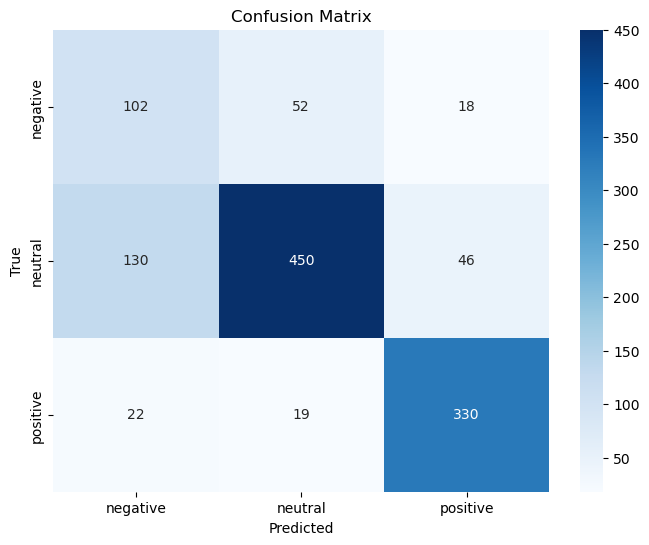

1/1 [==============================] - 0s 52ms/step


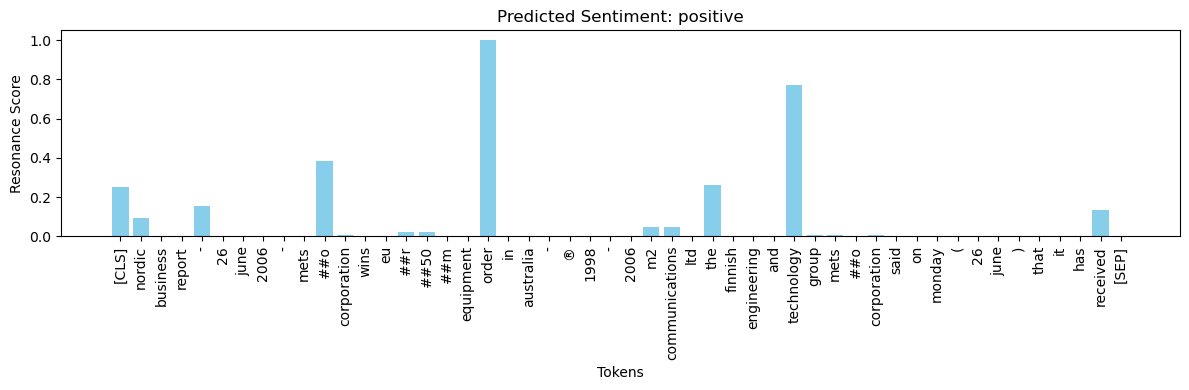

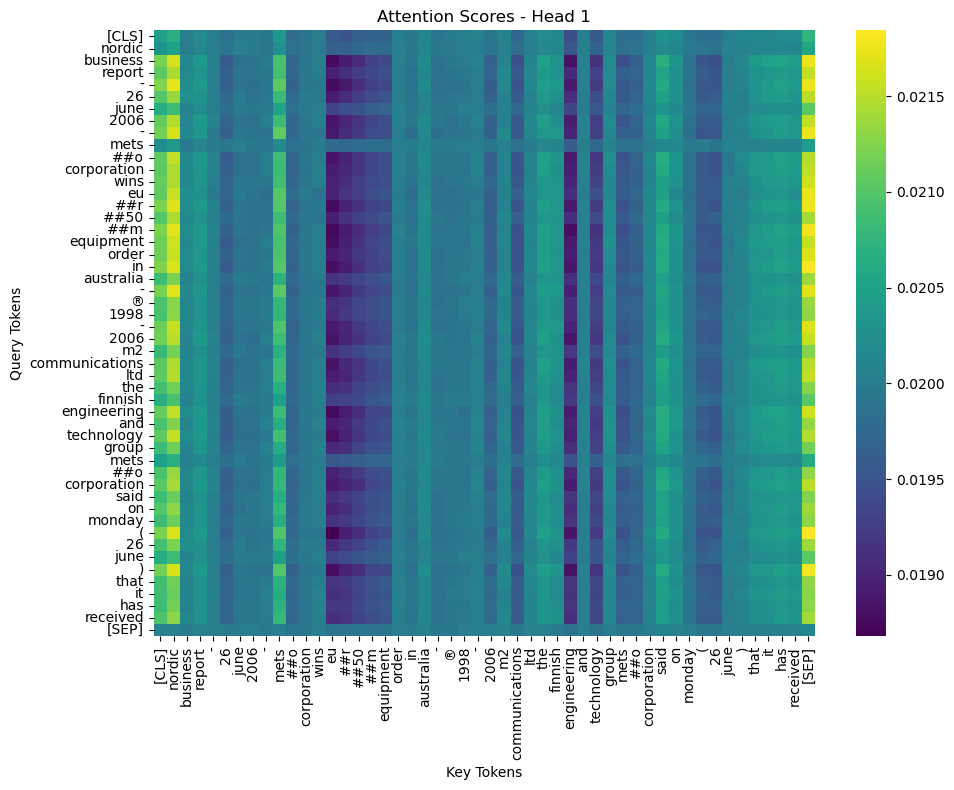

In [7]:
# -------------------------------
# 7. Detailed Model Evaluation
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def decode_tokens(input_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return tokens

def visualize_resonance_scores(tokens, resonance_scores, predicted_label, label_encoder):
    """
    Plots resonance scores for each token in the sentence.
    """
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(tokens)), resonance_scores, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(f"Predicted Sentiment: {label_encoder.inverse_transform([predicted_label])[0]}")
    plt.xlabel("Tokens")
    plt.ylabel("Resonance Score")
    plt.tight_layout()
    plt.show()

def visualize_attention_scores(tokens, attention_scores, head=0):
    """
    Plots attention scores for a specific head in the Multi-Head Attention layer.
    """
    # Select the desired head
    attention = attention_scores[0][head]  # Shape: (seq_length, seq_length)
    # No need to call .numpy() since attention_scores is already a NumPy array
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Attention Scores - Head {head+1}')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Predict on the test set
all_predictions = []
all_labels = []
all_resonance_scores = []

for batch_inputs, batch_labels in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']
    
    predictions, resonance_scores, attention_scores = model.predict([input_ids, attention_masks, adjacency])
    predicted_labels = np.argmax(predictions, axis=1)
    
    all_predictions.extend(predicted_labels)
    
    # Handle batch_labels correctly
    if isinstance(batch_labels, tf.Tensor):
        all_labels.extend(batch_labels.numpy())
    else:
        all_labels.extend(batch_labels)
    
    # Remove .numpy() as resonance_scores is already a NumPy array
    all_resonance_scores.extend(resonance_scores)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='macro')
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Macro F1 Score: {f1:.4f}")
print(f"Test Macro Precision: {precision:.4f}")
print(f"Test Macro Recall: {recall:.4f}")

# Per-class metrics
precision_per_class = precision_score(all_labels, all_predictions, average=None)
recall_per_class = recall_score(all_labels, all_predictions, average=None)
f1_per_class = f1_score(all_labels, all_predictions, average=None)

for idx, class_label in enumerate(label_encoder.classes_):
    print(f"Class: {class_label}")
    print(f"  Precision: {precision_per_class[idx]:.4f}")
    print(f"  Recall:    {recall_per_class[idx]:.4f}")
    print(f"  F1-Score:  {f1_per_class[idx]:.4f}\n")

# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(all_labels, all_predictions).numpy()
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualizing Resonance Scores for a Sample Sentence
# Select a sample from the test set
sample_index = 0  # Change as needed
sample_input_ids = X_test_ids[sample_index:sample_index+1]
sample_attention_masks = X_test_masks[sample_index:sample_index+1]
sample_adjacency = adjacency_test[sample_index:sample_index+1]
sample_label = y_test[sample_index]

# Predict sentiment and get resonance scores
predictions, resonance_scores, attention_scores = model.predict([sample_input_ids, sample_attention_masks, sample_adjacency])
predicted_label = np.argmax(predictions, axis=1)[0]

# Decode tokens
tokens = decode_tokens(sample_input_ids[0], tokenizer)

# Extract and normalize resonance scores
resonance = resonance_scores[0].squeeze()[:len(tokens)]
# Ensure resonance is float32 to match plotting
resonance_normalized = (resonance - np.min(resonance)) / (np.max(resonance) - np.min(resonance) + 1e-8)
resonance_normalized = resonance_normalized.astype(np.float32)

# Visualize resonance scores
visualize_resonance_scores(
    tokens=tokens,
    resonance_scores=resonance_normalized,
    predicted_label=predicted_label,
    label_encoder=label_encoder
)

# Visualize attention scores for the first head
visualize_attention_scores(tokens, attention_scores, head=0)


In [8]:
df.shape

(5842, 2)